In [10]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import pyrealsense2 as rs
import cv2

sys.path.append("../../")

from scripts.SurfaceContact.move import move_default_pose
from scripts.USImageCV.models.unet import UNet
from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Connect to robot

In [3]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")



# Connect to ultrasound image stream

In [4]:
ultrasoud_vid = cv2.VideoCapture('/dev/video8')

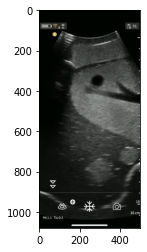

In [5]:

ret, frame = ultrasoud_vid.read()		
plt.imshow(frame)

# Load pre-trained bunny segmentation model

In [6]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = load_bunny_model('../../scripts/USImageCV/model_weights/bunny_seg_model.pth',device)

# Find surface

In [11]:
pipeline = rs.pipeline()
pipeline.start()


In [13]:

from scripts.SurfaceContact.control import SurfaceContactControl

In [14]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (227,124,100)
body_hsv_rad = (5,50,100)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [24]:
move_default_pose(rtde_c)

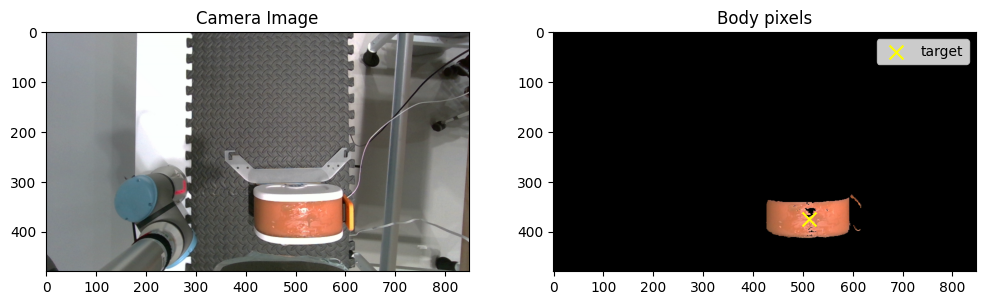

In [25]:
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sc.showScene([ax1,ax2])


In [184]:

def find_surface(sc):
    for _ in range(40):
        dist = sc.mainloop()
        dist_threshold = 0.005
        if dist<dist_threshold:
            break
    print("Arrived at above target location. Start descending.")

    sc.loc_normal_control(hover_height=0.20)
    # s = input("Find surface:?")

    if sc.getContact():
        print("Contact made.")

In [112]:
move_default_pose(rtde_c)
# Record force zero
w0 = rtde_r.getActualTCPForce()

In [113]:
find_surface(sc)

Arrived at above target location. Start descending.
Contact made.


# Simple force control

In [150]:
from force_control import z_force_control

In [182]:
target_force = 10
force_err_tolerance = 0.2

z_force_control(target_force,rtde_r,rtde_c,w0)

Current force is:10.514750509943742:  Time elapsed=00:00

Target force reached.


True

In [7]:
import time
from collections import deque

def y_direction_search():
    # y direction search has to be very careful, with low speed vel=0.001
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[0,-0.01,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[0,+0.01,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.001,
                        search_acc = 0.1)

def x_direction_search():
    # x direction search can be more crude, with intermediate speed vel=0.01
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[-0.05,0,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[+0.05,0,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.01,
                        search_acc = 0.1)

def bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                     ultrasoud_vid,
                     model,device,
                     search_vel=0.001,
                     search_acc=0.1):
    # Optimize the bunny view by traversing the robot from a start pose to a goal pose.

    # Move the TCP to the starting pose.
    rtde_c.moveL(start_pose,0.01,0.1) 
    
    # After reaching the starting pose, fire off the TCP to move towards the target_pose.
    # Setting asynchoronous=True allows the code to fly forward while the robot execute the motion independently.
    rtde_c.moveL(target_pose,search_vel,search_acc,asynchronous=True) 
    
    # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
    speeds = []
    start_time = time.time()

    time.sleep(0.01) # This will allow the robot to start moving a little
    area_diff = deque(maxlen=3)

    max_area = 0
    optim_pose = []
    frames = []
    for i in range(1000):
        linear_tcp_speed = np.linalg.norm(rtde_r.getActualTCPSpeed()[:3])
        speeds.append(linear_tcp_speed)
        
        ret, frame = ultrasoud_vid.read()	
        frames.append(frame)
        ###### Must record the curr_pose right after the image read and before the neural network inference.
        curr_pose = rtde_r.getActualTCPPose()	
        ######


        mask = bunny_mask_predict(model,frame,device)
        area = max_connected_area(mask)
        # print("area",area,"Time elapsed:",time.time()-start_time)
        area_diff.append(area)
        
        if area>max_area:
            max_area = area
            optim_pose = curr_pose
        
        if len(area_diff)>=3 and\
             np.min(area_diff)>4000 and \
                area_diff[-1]-area_diff[-2]<0 and area_diff[-2]-area_diff[-3]<0:
            # If the area starts to consistently decline, stop the robot. 
            # print(list(area_diff))
            rtde_c.stopL() 
            # We can call stopL() to manually stop the robot during execution.
            # This is very useful pairing with the async move of moveL.

            # And move the robot to the optimal pose
            rtde_c.moveL(optim_pose,0.01,0.1)

            return max_area,frames
        
        if linear_tcp_speed<1e-4:
            return max_area,frames

In [183]:
def find_bunny():
    max_a = 0
    while True:
        y_direction_search()
        
        a,_ = x_direction_search()
        print('Max area',a)
        if a>=max_a:
            max_a = a
        if max_a>=13000:
            break


# Clean up

In [185]:
ultrasoud_vid.release()
pipeline.stop()

# Useful Scripts

In [ ]:
# Script for saving default pose
with open('../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)